FYP - SHESelect Sentiment Analysis Model using Naive Bayes & BERT algorithm

In [ ]:
#IMPORT NECESSARY LIBRARIES
import nltk
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
#Used to optimize the model
import swifter
import spacy
#Naive Bayes and BERT algorithms
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from tf_keras import mixed_precision
from tf_keras.optimizers import Adam
from tf_keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#Hypertuning
from sklearn.model_selection import GridSearchCV #naive bayes
from tensorflow.keras.optimizers.schedules import ExponentialDecay #bert
from sklearn.model_selection import ParameterGrid
import optuna
from sklearn.preprocessing import LabelEncoder
from scikeras.wrappers import KerasClassifier
from tf_keras.callbacks import EarlyStopping
from imblearn.over_sampling import RandomOverSampler  # For dataset balancing


In [ ]:
!pip install swifter
!pip install scikeras
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16505 sha256=5130f93f9d76b069140cde559a7ef74c9909e5fcc3a98a81a3e94df3b6c4115b
  Stored in directory: /root/.cache/pip/wheels/ef/7f/bd/9bed48f078f3ee1fa75e0b29b6e0335ce1cb03a38d3443b3a3
Successfully built swifter
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 20.8 MB/s eta 0:00:00


In [ ]:
#IMPORT DATASET
#Load the reviews dataset for training
reviewdata = pd.read_csv('Reviews.csv') #import amazon fine food reviews dataset
print(reviewdata.head()) #print few first rows of dataset

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1 

In [ ]:
#EXTRACT IMPORTANT COLUMNS SIGNIFICANTLY FOR TRAINING
reviews = reviewdata[['Score','Summary','Text']] #Extracted rating score, summary and review text data
print(reviews.head()) #print few first rows of the selected column

   Score                Summary  \
0      5  Good Quality Dog Food   
1      1      Not as Advertised   
2      4  "Delight" says it all   
3      2         Cough Medicine   
4      5            Great taffy   

                                                Text  
0  I have bought several of the Vitality canned d...  
1  Product arrived labeled as Jumbo Salted Peanut...  
2  This is a confection that has been around a fe...  
3  If you are looking for the secret ingredient i...  
4  Great taffy at a great price.  There was a wid...  


In [ ]:
#HANDLE MISSING VALUES AND DUPLICATES FOR SELECTED COLUMNS
reviews.dropna(inplace=True) #remove missing values
reviews.drop_duplicates(inplace=True) #remove duplicate values

C:\Users\joenl\AppData\Local\Temp\ipykernel_21764\2679524761.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews.dropna(inplace=True) #remove missing values
C:\Users\joenl\AppData\Local\Temp\ipykernel_21764\2679524761.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews.drop_duplicates(inplace=True) #remove duplicate values


In [ ]:
#REMOVE DATA OUTLIERS FOR SCORE COLUMN (NUMERICAL DATA)
#USING INTERQUARTILE RANGE METHOD (IQR)
if pd.api.types.is_numeric_dtype(reviews['Score']):
    Q1 = reviews['Score'].quantile(0.25)
    Q3 = reviews['Score'].quantile(0.75)
    IQR = Q3 - Q1

    lower_boundary = Q1 - 1.5*IQR
    upper_boundary = Q3 + 1.5*IQR

    reviews = reviews[(reviews['Score'] >= lower_boundary) & (reviews['Score'] <= upper_boundary)]

In [ ]:
#REMOVE DATA ANOMALIES FOR TEXT AND SUMMARY COLUMN (TEXT DATA)
reviews = reviews[(reviews['Text'].str.len() > 5) & (reviews['Text'].str.len() < 1000)]
reviews = reviews[(reviews['Summary'].str.len() > 3) & (reviews['Summary'].str.len() < 300)]

In [ ]:
reviews = reviews.drop_duplicates()
print(reviews.shape)  # Should still be (311049, columns)


(311049, 3)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\joenl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joenl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 311049/311049 [19:10<00:00, 270.39it/s]


   Score                                        Summary  \
0      5                          Good Quality Dog Food   
2      4                          "Delight" says it all   
4      5                                    Great taffy   
5      4                                     Nice Taffy   
6      5  Great!  Just as good as the expensive brands!   

                                                Text  \
0  I have bought several of the Vitality canned d...   
2  This is a confection that has been around a fe...   
4  Great taffy at a great price.  There was a wid...   
5  I got a wild hair for taffy and ordered this f...   
6  This saltwater taffy had great flavors and was...   

                                      Tokenized_text  \
0  bought several vitality canned dog food produc...   
2  confection around centuries light pillowy citr...   
4  great taffy great price wide assortment yummy ...   
5  got wild hair taffy ordered five pound bag taf...   
6  saltwater taffy great fla

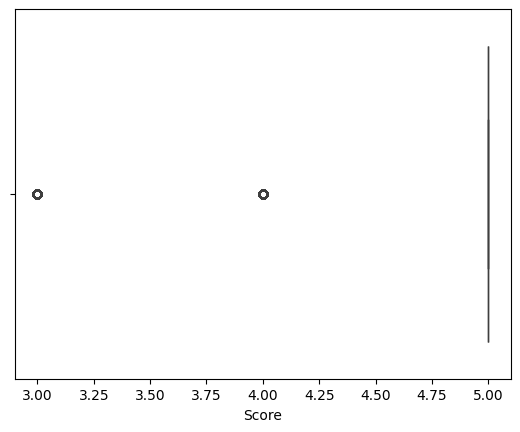

In [ ]:
#TEXT PREPROCESSING
#Import NLTK Resouces needed
nltk.download('punkt')
nltk.download('stopwords')
#Progress bar display
from tqdm import tqdm

#Load stopwords one time for efficiency
stop_words = set(stopwords.words('english'))

#Load spacy model for tokenization
spacy_token = spacy.load("en_core_web_sm", disable=["parser", "ner"])

#Progress bar using Pandas
tqdm.pandas()

#Create preprocessing function to clean and preprocess input texts
def preprocess_text(text):
    if pd.isna(text): #Check missing values
        return " "
    text = text.lower() #lower case the text
    text = re.sub(r'[^a-zA-Z]', ' ', text) #remove special characters from text
    text = re.sub(r'\s+', ' ', text).strip() #remove extra spaces between text
    #text = re.sub(r'\d+', ' ', text) #remove any numbers in text
    #tokens = word_tokenize(text) #tokenize the text
    tokens = [token.text for token in spacy_token(text) if token.text not in stop_words]
    #tokens = [word for word in tokens if word not in stopwords.words('english')] #remove stopwords
    return ' '.join(tokens)

#Apply preprocessing on the selected columns
reviews['Tokenized_text'] = reviews['Text'].progress_apply(preprocess_text)
reviews['Tokenized_summary'] = reviews['Summary'].progress_apply(preprocess_text)

#Display tokenized column results
print(reviews.head())

#Cleaned Score distribution
sns.boxplot(x=reviews['Score'])
plt.show()


In [ ]:
#SAVE PREPROCESSED DATA (CLEANED DATA)
reviews.to_csv('Preprocessed_reviews.csv', index=False, encoding='utf-8')


Run with the preprocessed data

In [ ]:
#Run only the cleaned preprocessed data
reviews = pd.read_csv('Preprocessed_reviews.csv', low_memory=False)
print(reviews.head().to_string(index=False, max_colwidth=50))

 Score                                       Summary                                               Text                                     Tokenized_text           Tokenized_summary
     5                         Good Quality Dog Food I have bought several of the Vitality canned do... bought several vitality canned dog food product...       good quality dog food
     4                         "Delight" says it all This is a confection that has been around a few... confection around centuries light pillowy citru...                delight says
     5                                   Great taffy Great taffy at a great price.  There was a wide... great taffy great price wide assortment yummy t...                 great taffy
     4                                    Nice Taffy I got a wild hair for taffy and ordered this fi... got wild hair taffy ordered five pound bag taff...                  nice taffy
     5 Great!  Just as good as the expensive brands! This saltwater taffy had great f

In [ ]:
#Convert numerical scores into sentiment labels for classification

def classify_sentiment(score):
    if score >= 5:
        return 'Positive'
    elif score == 4:
        return 'Neutral'
    else:
        return 'Negative'

#Apply sentiment labels
reviews['Sentiment'] = reviews['Score'].apply(classify_sentiment)

print(reviews[['Score', 'Sentiment']].tail(30))

        Score Sentiment
311019      5  Positive
311020      4   Neutral
311021      5  Positive
311022      5  Positive
311023      4   Neutral
311024      5  Positive
311025      3  Negative
311026      5  Positive
311027      5  Positive
311028      5  Positive
311029      5  Positive
311030      5  Positive
311031      5  Positive
311032      5  Positive
311033      5  Positive
311034      5  Positive
311035      5  Positive
311036      4   Neutral
311037      5  Positive
311038      5  Positive
311039      5  Positive
311040      5  Positive
311041      5  Positive
311042      5  Positive
311043      5  Positive
311044      5  Positive
311045      5  Positive
311046      5  Positive
311047      5  Positive
311048      5  Positive


In [ ]:
#Define X (features) and y (target variable)

X = reviews['Tokenized_text']
y = reviews['Sentiment']

In [ ]:
#SPLIT TO TEST AND TRAIN SETS
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [ ]:
#TRAINING AND TESTING SETS

# Concatenate X_train and y_train to drop NaNs consistently
train_data = pd.DataFrame({'text': X_train, 'label': y_train})
train_data = train_data.dropna()

# Separate
X_train = train_data['text']
y_train = train_data['label']


print("Training data size: ", len(X_train), len(y_train))
print("Testing data size: ", len(X_test))

Training data size:  248838 248838
Testing data size:  62210


In [ ]:
#Train Naive Bayes algorithm as simple baseline
#Convert all text data into TF-IDF features
NB_vectorizer = TfidfVectorizer(max_features=5000)
X_train_Tfidf = NB_vectorizer.fit_transform(X_train)
X_test_Tfidf = NB_vectorizer.transform(X_test)

# Encode labels
label_map = {'Positive': 0, 'Neutral': 1, 'Negative': 2}
y_train_encoded = np.array([label_map[label] for label in y_train])
y_test_encoded = np.array([label_map[label] for label in y_test])


In [ ]:
#Train Naive Bayes model
NaiveBayes = MultinomialNB()
NaiveBayes.fit(X_train_Tfidf, y_train_encoded)

# Get probability predictions
NaiveBayes_ypred_prob = NaiveBayes.predict_proba(X_test_Tfidf) #prob predictions
NaiveBayes_ypred = NaiveBayes.predict(X_test_Tfidf)  # Class labels

In [ ]:
#Print evaluation matrix and accuracy for NB algorithm
print("NB algorithm accuracy: ", accuracy_score(y_test_encoded, NaiveBayes_ypred))
print(classification_report(y_test_encoded, NaiveBayes_ypred))
print(confusion_matrix(y_test_encoded, NaiveBayes_ypred))

NB algorithm accuracy:  0.7574987944060441
              precision    recall  f1-score   support

           0       0.76      1.00      0.86     46859
           1       0.49      0.02      0.04     10168
           2       0.73      0.02      0.05      5183

    accuracy                           0.76     62210
   macro avg       0.66      0.35      0.32     62210
weighted avg       0.71      0.76      0.66     62210

[[46778    73     8]
 [ 9912   217    39]
 [ 4899   155   129]]


In [ ]:
#Train BERT algorithm for complex patterns

# Enable mixed precision and XLA
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
tf.config.optimizer.set_jit(True)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

#Load the Bert tokenizer and model
Bert_tokens = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
Bert = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

#Function to tokenize text data
def encode_texts(texts, max_length=128):
    return Bert_tokens(list(texts, padding=True, truncation=True, return_tensors="tf", max_length=max_length))

#Tokenize and encode training data
X_train_encoded = Bert_tokens(
    X_train.tolist(),
    padding='longest',
    truncation=True,
    return_tensors="tf",
    max_length=128 #adjust based on dataset size
)

X_test_encoded = Bert_tokens(
    X_test.tolist(),
    padding=True,
    truncation=True,
    return_tensors="tf",
    max_length=128 #adjust based on dataset size
)

#Convert y labels to numerical format
label_map = {'Positive': 0, 'Neutral': 1, 'Negative': 2}
y_train_encoded = np.array([label_map[label] for label in y_train])
y_test_encoded = np.array([label_map[label] for label in y_test])

#Train BERT model by passing Adam as string
Bert.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

#Early stopping for faster training time
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

#Convert input data to TensorFlow tensors
X_train_tf = tf.convert_to_tensor(X_train_encoded['input_ids'], dtype=tf.int32)
y_train_tf = tf.convert_to_tensor(y_train_encoded, dtype=tf.int32)
X_test_tf = tf.convert_to_tensor(X_test_encoded['input_ids'], dtype=tf.int32)
y_test_tf = tf.convert_to_tensor(y_test_encoded, dtype=tf.int32)

Bert.fit(
    X_train_tf, y_train_tf,
    epochs=4,
    batch_size=32,
    validation_data=(X_test_tf, y_test_tf),
    callbacks=[early_stopping]
)

#Probability predictions for BERT
Bert_ypred_logits = Bert.predict(X_test_encoded['input_ids']).logits
Bert_ypred_prob = tf.nn.softmax(Bert_ypred_logits).numpy()

#Convert probabilities to class labels
Bert_ypred = np.argmax(Bert_ypred_prob, axis=1)
y_test_encoded = np.array([label_map[label] for label in y_test])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/4
7777/7777 [==============================] - 914s 112ms/step - loss: 0.7221 - accuracy: 0.7556 - val_loss: 0.7175 - val_accuracy: 0.7532
Epoch 2/4
7777/7777 [==============================] - 848s 109ms/step - loss: 0.7148 - accuracy: 0.7560 - val_loss: 0.7170 - val_accuracy: 0.7532
Epoch 3/4
7777/7777 [==============================] - 840s 108ms/step - loss: 0.7132 - accuracy: 0.7560 - val_loss: 0.7166 - val_accuracy: 0.7532
Epoch 4/4
1945/1945 [==============================] - 59s 29ms/step


In [ ]:
#Print evaluation matrix and accuracy for BERT algorithm
print("BERT algorithm accuracy: ", accuracy_score(y_test_encoded, Bert_ypred))
print(classification_report(y_test_encoded, Bert_ypred))
print(confusion_matrix(y_test_encoded, Bert_ypred))

BERT algorithm accuracy:  0.7532390290950008
              precision    recall  f1-score   support

           0       0.75      1.00      0.86     46859
           1       0.00      0.00      0.00     10168
           2       0.00      0.00      0.00      5183

    accuracy                           0.75     62210
   macro avg       0.25      0.33      0.29     62210
weighted avg       0.57      0.75      0.65     62210

[[46859     0     0]
 [10168     0     0]
 [ 5183     0     0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#Combine both predictions (Naive Bayes + BERT)
NaiveBayes_ypred_prob = np.array(NaiveBayes_ypred_prob)
Bert_ypred_prob = np.array(Bert_ypred_prob)

#Weighted average for model (More weight to BERT)
Final_prob = (0.4* NaiveBayes_ypred_prob) + (0.6* Bert_ypred_prob)
Final_pred = np.argmax(Final_prob, axis=1)

#Ensemble model evaluation
print("Final model accuracy: ", accuracy_score(y_test_encoded, Final_pred))
print(classification_report(y_test_encoded, Final_pred))
print(confusion_matrix(y_test_encoded, Final_pred))

Final model accuracy:  0.7532390290950008
              precision    recall  f1-score   support

           0       0.75      1.00      0.86     46859
           1       0.00      0.00      0.00     10168
           2       0.00      0.00      0.00      5183

    accuracy                           0.75     62210
   macro avg       0.25      0.33      0.29     62210
weighted avg       0.57      0.75      0.65     62210

[[46859     0     0]
 [10168     0     0]
 [ 5183     0     0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#Apply hypertuning to the result
#Naive Bayes (use GridSearchCV)

#Define hyperparameter grid for NB
parameter_grid = {
    'alpha': [0.1, 0.5, 1.0, 5, 10] #smoothing parameter (main hyperparameter)
}

#Initialize NB model
NB_model = MultinomialNB()

#Set GridSearchCV
grid_search = GridSearchCV(
    estimator=NB_model,
    param_grid=parameter_grid,
    cv=5, #use 5 fold cross validation
    scoring='accuracy',
    n_jobs=-1 #use available processors
)

#Perform GridSearch
grid_search.fit(X_train_Tfidf, y_train)

#Print best parameters and score
print('Best Parameters: ', grid_search.best_params_)
print('Best Cross Validation Accuracy: ', grid_search.best_score_)

#Perform predictions on best parameters
NB_model_best = grid_search.best_estimator_
y_pred_best = NB_model_best.predict(X_test_Tfidf)

#Print Final model accuracy
print('Model Accuracy with best parameters: ', accuracy_score(y_test, y_pred_best))

Best Parameters:  {'alpha': 0.1}
Best Cross Validation Accuracy:  0.7601290817653602
Model Accuracy with best parameters:  0.7580614049188233


In [ ]:
#BERT hypertuning (train once only)
# Load tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenization function
def tokenize_data(X_data):
    encodings = tokenizer(
        list(X_data), padding="max_length", truncation=True, max_length=64, return_tensors="tf"
    )
    return {'input_ids': encodings['input_ids'], 'attention_mask': encodings['attention_mask']}

# Tokenize train and test sets
X_train_encoded = tokenize_data(X_train)
X_test_encoded = tokenize_data(X_test)

# Convert labels to NumPy arrays
y_train_np = np.array(y_train_encoded, dtype=np.int64)
y_test_np = np.array(y_test_encoded, dtype=np.int64)

# Create TF Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_encoded, y_train_np)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_encoded, y_test_np)).batch(32).prefetch(tf.data.AUTOTUNE)

# Define the function to create a BERT model
def bert_model(learning_rate):
    model = TFDistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased', num_labels=3
    )

    # Create a function to return the learning rate for the current step
    def lr_scheduler(epoch, lr):
        lr_schedule = ExponentialDecay(
            initial_learning_rate=learning_rate, decay_steps=1000, decay_rate=0.9, staircase=True
        )
        return lr_schedule(epoch)  # Pass the epoch as the step

    # Update the learning rate using the lr_scheduler before each epoch
    class CustomCallback(tf.keras.callbacks.Callback):
        def on_epoch_begin(self, epoch, logs=None):
            lr = lr_scheduler(epoch, self.model.optimizer.lr.numpy())
            tf.keras.backend.set_value(self.model.optimizer.lr, lr)

        # Add the missing methods to make the callback compatible with TensorFlow
        def _implements_train_batch_hooks(self):
            return False

        def _implements_test_batch_hooks(self):
            return False

        def _implements_predict_batch_hooks(self):
            return False

    optimizer = Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model, CustomCallback()  # Return the custom callback

# Define selected hyperparameters
selected_params = {
    'learning_rate': 5e-5,  # Selected learning rate
    'batch_size': 16,  # Selected batch size
    'epochs': 3  # Selected number of epochs
}

print(f"\nTraining with Selected Hyperparameters: {selected_params}")

# Create model with selected hyperparameters
model, custom_callback = bert_model(learning_rate=selected_params['learning_rate'])

# Train the model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=selected_params['epochs'],
    callbacks=[custom_callback],  # Use custom callback
    verbose=1
)

# Evaluate the model
y_pred = model.predict(test_dataset)
y_pred = np.argmax(y_pred.logits, axis=1)  # Extract predictions

# Compute final accuracy
final_accuracy = accuracy_score(y_test_np, y_pred)
print("\nFinal Model Accuracy:", final_accuracy)



Training with Selected Hyperparameters: {'learning_rate': 5e-05, 'batch_size': 16, 'epochs': 3}


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
7777/7777 [==============================] - 569s 69ms/step - loss: 0.5448 - accuracy: 0.7877 - val_loss: 0.5246 - val_accuracy: 0.7933
Epoch 2/3
7777/7777 [==============================] - 514s 66ms/step - loss: 0.4736 - accuracy: 0.8141 - val_loss: 0.5283 - val_accuracy: 0.7978
Epoch 3/3
1945/1945 [==============================] - 33s 16ms/step

Final Model Accuracy: 0.7929271821250603


In [ ]:
#Add both hypertune predictions

# Get predictions from best NB model and BERT model
y_pred_NB = NB_model_best.predict(X_test_Tfidf)
y_pred_Bert_output = model.predict(X_test_encoded)

# Extract logits from BERT output and convert to class predictions
y_pred_Bert = np.argmax(y_pred_Bert_output.logits, axis=1)

# Ensemble method using Majority Voting
# If both models predict the same, use it; else, prioritize BERT

y_pred_ensemble = []
for bert, nb in zip(y_pred_Bert, y_pred_NB):
    if bert == nb:
        y_pred_ensemble.append(bert)  # Both agree, take the prediction
    else:
        y_pred_ensemble.append(bert)  # Prioritize BERT

# Convert list to NumPy array
y_pred_ensemble = np.array(y_pred_ensemble)

1945/1945 [==============================] - 33s 15ms/step


In [ ]:
#Print final result with prediction results and accuracy
print("Final model accuracy: ", accuracy_score(y_test_encoded, y_pred_ensemble))
print(classification_report(y_test_encoded, y_pred_ensemble))
print(confusion_matrix(y_test_encoded, y_pred_ensemble))


Final model accuracy:  0.7929271821250603
              precision    recall  f1-score   support

           0       0.84      0.95      0.89     46859
           1       0.50      0.23      0.31     10168
           2       0.55      0.45      0.49      5183

    accuracy                           0.79     62210
   macro avg       0.63      0.54      0.57     62210
weighted avg       0.76      0.79      0.76     62210

[[44678  1348   833]
 [ 6772  2318  1078]
 [ 1925   926  2332]]


In [ ]:
#Save hybrid sentiment analysis model
import joblib
import os

# Save Naive Bayes and TF-IDF vectorizer
hybrid_model = {
    'naive_bayes_model': NaiveBayes,
    'tfidf_vectorizer': NB_vectorizer,
}

# Save as .pkl (only for the scikit-learn models)
joblib.dump(hybrid_model, 'hybrid_sentimentmodel.pkl')
print("Naive Bayes & TF-IDF saved.")

# Save BERT model and tokenizer separately
save_path = './bert-sentiment-model'
os.makedirs(save_path, exist_ok=True)

model.save_pretrained(save_path) #resave this
tokenizer.save_pretrained(save_path)
print("BERT model & tokenizer saved at:", save_path)


Naive Bayes & TF-IDF saved.
BERT model & tokenizer saved at: ./bert-sentiment-model
